In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

annual_image_path = "Annual_Images/"
daily_image_path = "Daily_Images/"

## Bonneville Dam Data Source

http://www.cbr.washington.edu/dart/query/adult_daily


In [3]:
# Create a list of dataframes to concat later
bonneville_salmon_list = []

# Loop through all the files and add them to the list
for i in range(8,21):
    
    # Read in Bonneville Dam Spring Chinook Counts
    bonneville_file = f"Resources/adultdaily_bonneville_20{i:02}.csv"
    
    # Grab only the columns we want
    bonneville_salmon_df = pd.read_csv(bonneville_file, usecols=["Project","Date","Chin"])
    
    # Append the df to the list
    bonneville_salmon_list.append(bonneville_salmon_df)

# Concat the list of dataframes    
combined_bonneville_salmon_df = pd.concat(bonneville_salmon_list)

# Clean up the na's with zero values
combined_bonneville_salmon_df["Chin"] = combined_bonneville_salmon_df["Chin"].fillna(0)

# Clean up data types
combined_bonneville_salmon_df["Chin"] = combined_bonneville_salmon_df["Chin"].astype('int')


combined_bonneville_salmon_df

,Project,Date,Chin
0,Bonneville,2008-03-01,0
1,Bonneville,2008-03-02,0
2,Bonneville,2008-03-03,1
3,Bonneville,2008-03-04,1
4,Bonneville,2008-03-05,0
...,...,...,...
87,Bonneville,2020-05-27,1238
88,Bonneville,2020-05-28,1016
89,Bonneville,2020-05-29,1485
90,Bonneville,2020-05-30,1309


In [4]:
yearly_bonneville_salmon_df = combined_bonneville_salmon_df.copy(deep=True)
yearly_bonneville_salmon_df[["Year", "Month", "Day"]] = yearly_bonneville_salmon_df['Date'].str.split('-', expand=True)
yearly_bonneville_salmon_df= yearly_bonneville_salmon_df.groupby("Year").agg({"Chin":"sum"}).reset_index()
yearly_bonneville_salmon_df["Year"] = yearly_bonneville_salmon_df["Year"].astype('int')
yearly_bonneville_salmon_df

,Year,Chin
0,2008,125582
1,2009,114548
2,2010,244419
3,2011,167132
4,2012,158088
5,2013,83339
6,2014,188079
7,2015,220471
8,2016,137204
9,2017,83623


In [6]:
# Save dataframe to csv file
yearly_bonneville_salmon_df.to_csv(r'Resources\Below_Bonneville_Salmon_Count.csv', index = False)

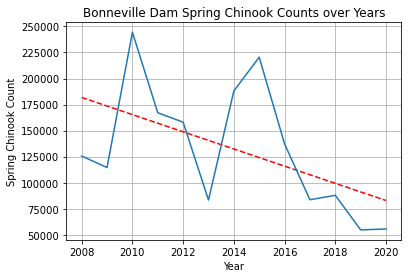

In [4]:
# Calculate a trend line
z = np.polyfit(yearly_bonneville_salmon_df["Year"], yearly_bonneville_salmon_df["Chin"], 1)
p = np.poly1d(z)

# Quick Plot of the Spring Chinook Counts over Years
fig, ax = plt.subplots()
ax.set_xlabel("Year")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Counts over Years")
ax.grid(True)
ax.plot(yearly_bonneville_salmon_df["Year"],p(yearly_bonneville_salmon_df["Year"]),"r--")
ax.plot(yearly_bonneville_salmon_df["Year"], yearly_bonneville_salmon_df["Chin"] )
plt.savefig(annual_image_path + "bonn_annual_salmon.png")
plt.show()

## Bonneville Below Data Source

https://waterdata.usgs.gov/usa/nwis/uv?site_no=14128870

mapper: https://maps.waterdata.usgs.gov/mapper/index.html

In [5]:
# Create bonneville below gage df
bonneville_below_gage_file = "Resources/Columbia_bonne-below.csv"
bonneville_below_gage_df = pd.read_csv(bonneville_below_gage_file, sep="\t")
bonneville_below_gage_df.head()

,agency_cd,site_no,datetime,Gage_Max,Status_Gage_Max,Gage_Min,Status_Gage_Min,Gage_Mean,Status_Gage_Mean
0,USGS,14128870,2000-01-01,15.97,A,14.21,A,15.00,A
1,USGS,14128870,2000-01-02,17.87,A,14.33,A,16.33,A
2,USGS,14128870,2000-01-03,19.86,A,15.99,A,17.40,A
3,USGS,14128870,2000-01-04,19.04,A,16.16,A,17.49,A
4,USGS,14128870,2000-01-05,19.24,A,15.70,A,17.02,A


In [6]:
# Clean the dataframe up and parse the dates
clean_bonneville_below_gage_df = bonneville_below_gage_df[["agency_cd", "site_no", "datetime", "Gage_Mean" ]].copy(deep=True)
clean_bonneville_below_gage_df = clean_bonneville_below_gage_df.rename(columns={"datetime":"Date"})
clean_bonneville_below_gage_df.head()

,agency_cd,site_no,Date,Gage_Mean
0,USGS,14128870,2000-01-01,15.00
1,USGS,14128870,2000-01-02,16.33
2,USGS,14128870,2000-01-03,17.40
3,USGS,14128870,2000-01-04,17.49
4,USGS,14128870,2000-01-05,17.02


In [7]:
# Check the types now
clean_bonneville_below_gage_df.dtypes

agency_cd     object
site_no        int64
Date          object
Gage_Mean    float64
dtype: object

In [8]:
# Merge Salmon Data with Gage data
merged_bonneville_salmon_data_df = pd.merge(combined_bonneville_salmon_df, clean_bonneville_below_gage_df, on="Date")
merged_bonneville_salmon_data_df[merged_bonneville_salmon_data_df.isna().any(axis=1)]

,Project,Date,Chin,agency_cd,site_no,Gage_Mean
921,Bonneville,2018-03-02,0,USGS,14128870,NaN
922,Bonneville,2018-03-03,0,USGS,14128870,NaN
923,Bonneville,2018-03-04,0,USGS,14128870,NaN
924,Bonneville,2018-03-05,0,USGS,14128870,NaN
966,Bonneville,2018-04-16,27,USGS,14128870,NaN
967,Bonneville,2018-04-17,39,USGS,14128870,NaN


In [9]:
clean_gage_df = merged_bonneville_salmon_data_df.dropna()
clean_gage_df[clean_gage_df.isna().any(axis=1)]

,Project,Date,Chin,agency_cd,site_no,Gage_Mean


In [10]:
clean_gage_df = clean_gage_df[
    clean_gage_df["Chin"] != 0
]
clean_gage_df

,Project,Date,Chin,agency_cd,site_no,Gage_Mean
2,Bonneville,2008-03-03,1,USGS,14128870,12.46
3,Bonneville,2008-03-04,1,USGS,14128870,14.08
5,Bonneville,2008-03-06,1,USGS,14128870,13.56
6,Bonneville,2008-03-07,1,USGS,14128870,13.75
7,Bonneville,2008-03-08,3,USGS,14128870,13.37
...,...,...,...,...,...,...
1191,Bonneville,2020-05-27,1238,USGS,14128870,22.96
1192,Bonneville,2020-05-28,1016,USGS,14128870,23.27
1193,Bonneville,2020-05-29,1485,USGS,14128870,25.13
1194,Bonneville,2020-05-30,1309,USGS,14128870,25.49


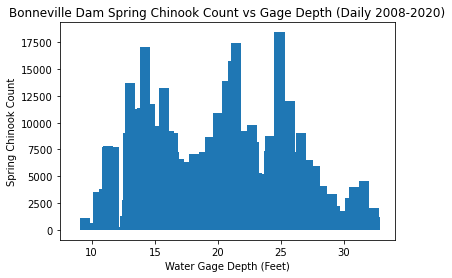

In [11]:
# Plot bar char distribution
fig, ax = plt.subplots()
ax.set_xlabel("Water Gage Depth (Feet)")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Count vs Gage Depth (Daily 2008-2020)")
ax.bar(clean_gage_df["Gage_Mean"], clean_gage_df["Chin"])
plt.savefig(daily_image_path + "bonn_below_daily_bar_gage.png")
plt.show()

The r-value is: 0.0933363146319209
The r2-value is: 0.00871166762906893
The p-value is: 0.0020767284639224854


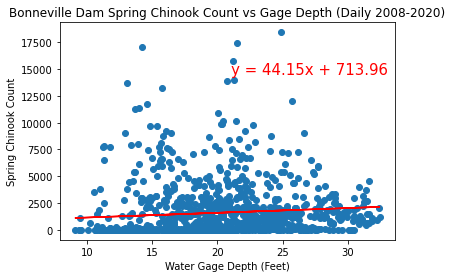

In [12]:
# Plot a scatter and regression of river depth and salmon counts to see if any correlation

slope, intercept, rvalue, pvalue, stderr = linregress(clean_gage_df["Gage_Mean"], 
                                                      clean_gage_df["Chin"])
regress_values =clean_gage_df["Gage_Mean"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
print(f"The r2-value is: {rvalue**2}")
print(f"The p-value is: {pvalue}")

fig, ax = plt.subplots()
ax.set_xlabel("Water Gage Depth (Feet)")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Count vs Gage Depth (Daily 2008-2020)")
ax.annotate(line_eq, (21,14500), fontsize=15, color="red")
ax.plot(clean_gage_df["Gage_Mean"], regress_values, "r-")
ax.scatter(clean_gage_df["Gage_Mean"], clean_gage_df["Chin"])
plt.savefig(daily_image_path + "bonn_below_daily_scatter_gage.png")
plt.show()

In [13]:
clean_gage_df[['Year','Month','Day']] = clean_gage_df['Date'].str.split('-', expand=True)
clean_gage_mean_df = clean_gage_df.groupby("Year").mean()
clean_gage_mean_df = clean_gage_mean_df.reset_index()
clean_gage_mean_df["Year"] = clean_gage_mean_df["Year"].astype("int")
clean_gage_mean_df

,Year,Chin,site_no,Gage_Mean
0,2008,1411.033708,14128870,17.372022
1,2009,1363.666667,14128870,18.198571
2,2010,2809.413793,14128870,13.868506
3,2011,1857.022222,14128870,23.174444
4,2012,1976.100000,14128870,23.714375
5,2013,905.858696,14128870,17.798370
6,2014,2411.269231,14128870,21.366795
7,2015,2396.423913,14128870,16.101739
8,2016,1507.736264,14128870,19.868242
9,2017,1194.614286,14128870,27.547286


In [14]:
merged_bonneville_salmon_data_df = pd.merge(yearly_bonneville_salmon_df, clean_gage_mean_df, on="Year")
merged_bonneville_salmon_data_df = merged_bonneville_salmon_data_df.drop(columns=["Chin_y"])
merged_bonneville_salmon_data_df = merged_bonneville_salmon_data_df.rename(columns={"Chin_x":"Chin"})
merged_bonneville_salmon_data_df

,Year,Chin,site_no,Gage_Mean
0,2008,125582,14128870,17.372022
1,2009,114548,14128870,18.198571
2,2010,244419,14128870,13.868506
3,2011,167132,14128870,23.174444
4,2012,158088,14128870,23.714375
5,2013,83339,14128870,17.798370
6,2014,188079,14128870,21.366795
7,2015,220471,14128870,16.101739
8,2016,137204,14128870,19.868242
9,2017,83623,14128870,27.547286


The r-value is: -0.30226139405069735
The r2-value is: 0.09136195033347094
The p-value is: 0.31550146531750045


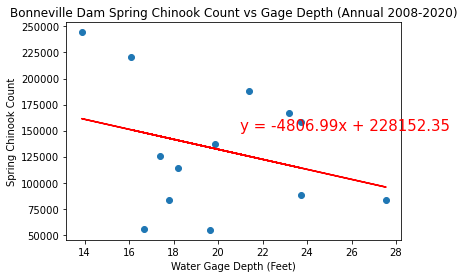

In [15]:
# Plot a scatter and regression of river depth and salmon counts to see if any correlation

slope, intercept, rvalue, pvalue, stderr = linregress(merged_bonneville_salmon_data_df["Gage_Mean"], 
                                                      merged_bonneville_salmon_data_df["Chin"])
regress_values =merged_bonneville_salmon_data_df["Gage_Mean"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
print(f"The r2-value is: {rvalue**2}")
print(f"The p-value is: {pvalue}")

fig, ax = plt.subplots()
ax.set_xlabel("Water Gage Depth (Feet)")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Count vs Gage Depth (Annual 2008-2020)")
ax.annotate(line_eq, (21,150000), fontsize=15, color="red")
ax.plot(merged_bonneville_salmon_data_df["Gage_Mean"], regress_values, "r-")
ax.scatter(merged_bonneville_salmon_data_df["Gage_Mean"], merged_bonneville_salmon_data_df["Chin"])
plt.savefig(annual_image_path + "bonn_below_annual_scatter_gage.png")
plt.show()

## Bonneville Below Dodson Data Source

https://waterdata.usgs.gov/usa/nwis/uv?site_no=453630122021400

mapper: https://maps.waterdata.usgs.gov/mapper/index.html

In [16]:
# Get Dodson Temperature Data just below Bonneville
below_bonneville_dodson_file = "Resources/columbia_dodson.csv"
below_bonneville_dodson_df = pd.read_csv(below_bonneville_dodson_file, sep="\t")
below_bonneville_dodson_df.head()

,agency_cd,site_no,datetime,tz_cd,temperature_c,status_temp,barometric,status_barmetric,pressure_gas,status_pressure_gas
0,USGS,453630122021400,2007-10-01 01:00,PDT,17.3,A,760.0,A,769.0,A
1,USGS,453630122021400,2007-10-01 02:00,PDT,17.2,A,761.0,A,767.0,A
2,USGS,453630122021400,2007-10-01 03:00,PDT,17.1,A,761.0,A,765.0,A
3,USGS,453630122021400,2007-10-01 04:00,PDT,17.1,A,762.0,A,764.0,A
4,USGS,453630122021400,2007-10-01 05:00,PDT,17.0,A,762.0,A,762.0,A


In [17]:
# Reduce data frame down to columns that I need
clean_below_bonneville_dodson_temp_df = below_bonneville_dodson_df[["agency_cd", "site_no", "datetime", "temperature_c" ]].copy(deep=True)
clean_below_bonneville_dodson_temp_df.head()

,agency_cd,site_no,datetime,temperature_c
0,USGS,453630122021400,2007-10-01 01:00,17.3
1,USGS,453630122021400,2007-10-01 02:00,17.2
2,USGS,453630122021400,2007-10-01 03:00,17.1
3,USGS,453630122021400,2007-10-01 04:00,17.1
4,USGS,453630122021400,2007-10-01 05:00,17.0


In [18]:
# Parse the date fields for a mean
clean_below_bonneville_dodson_temp_df[['Date','Hour']] = clean_below_bonneville_dodson_temp_df['datetime'].str.split(' ', expand=True)

# Calculate the daily mean
clean_below_bonneville_dodson_temp_mean_df = clean_below_bonneville_dodson_temp_df.groupby("Date").mean()
clean_below_bonneville_dodson_temp_mean_df

,site_no,temperature_c
Date,,
2007-10-01,453630122021400,17.091304
2007-10-02,453630122021400,16.883333
2007-10-03,453630122021400,16.916667
2007-10-04,453630122021400,16.729167
2007-10-05,453630122021400,16.354167
...,...,...
2020-10-31,453630122021400,13.275000
2020-11-01,453630122021400,12.996000
2020-11-02,453630122021400,12.895833


In [19]:
# Merge salmon data with temperature data
merged_clean_below_bonneville_dodson_temp_mean_df = pd.merge(combined_bonneville_salmon_df, clean_below_bonneville_dodson_temp_mean_df, on="Date" )

merged_clean_below_bonneville_dodson_temp_mean_df = merged_clean_below_bonneville_dodson_temp_mean_df.dropna()

# Create a Farenhieght Temperature
merged_clean_below_bonneville_dodson_temp_mean_df['temperature_f'] = merged_clean_below_bonneville_dodson_temp_mean_df['temperature_c'] * 1.8 + 32

# Get rid of any rows that don't have a temp
merged_clean_below_bonneville_dodson_temp_mean_df[merged_clean_below_bonneville_dodson_temp_mean_df.isna().any(axis=1)]


,Project,Date,Chin,site_no,temperature_c,temperature_f


In [20]:
merged_clean_below_bonneville_dodson_temp_mean_df = merged_clean_below_bonneville_dodson_temp_mean_df[
    merged_clean_below_bonneville_dodson_temp_mean_df["Chin"] != 0
]
merged_clean_below_bonneville_dodson_temp_mean_df

,Project,Date,Chin,site_no,temperature_c,temperature_f
2,Bonneville,2008-03-03,1,453630122021400,5.087500,41.1575
3,Bonneville,2008-03-04,1,453630122021400,5.058333,41.1050
5,Bonneville,2008-03-06,1,453630122021400,5.070833,41.1275
6,Bonneville,2008-03-07,1,453630122021400,5.083333,41.1500
7,Bonneville,2008-03-08,3,453630122021400,5.212500,41.3825
...,...,...,...,...,...,...
1104,Bonneville,2020-05-27,1238,453630122021400,13.504167,56.3075
1105,Bonneville,2020-05-28,1016,453630122021400,13.770833,56.7875
1106,Bonneville,2020-05-29,1485,453630122021400,14.050000,57.2900
1107,Bonneville,2020-05-30,1309,453630122021400,14.116667,57.4100


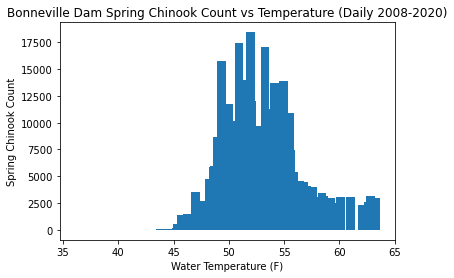

In [21]:
# Plot bar char distribution salmon vs temp
fig, ax = plt.subplots()
ax.set_xlabel("Water Temperature (F)")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Count vs Temperature (Daily 2008-2020)")
ax.bar(merged_clean_below_bonneville_dodson_temp_mean_df["temperature_f"], merged_clean_below_bonneville_dodson_temp_mean_df["Chin"])
plt.savefig(daily_image_path + "bonn_below_daily_bar_temp.png")
plt.show()

The r-value is: 0.4151871137555157
The r2-value is: 0.17238033942863554
The p-value is: 3.741386904825006e-43


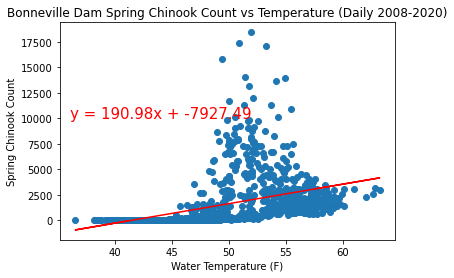

In [22]:
# Plot a scatter and regression of river temperature and salmon counts to see if any correlation

slope, intercept, rvalue, pvalue, stderr = linregress(merged_clean_below_bonneville_dodson_temp_mean_df["temperature_f"], 
                                                      merged_clean_below_bonneville_dodson_temp_mean_df["Chin"])
regress_values = merged_clean_below_bonneville_dodson_temp_mean_df["temperature_f"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
print(f"The r2-value is: {rvalue**2}")
print(f"The p-value is: {pvalue}")

fig, ax = plt.subplots()
ax.set_xlabel("Water Temperature (F)")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Count vs Temperature (Daily 2008-2020)")
ax.annotate(line_eq, (36,10000), fontsize=15, color="red")
ax.plot(merged_clean_below_bonneville_dodson_temp_mean_df["temperature_f"], regress_values, "r-")
ax.scatter(merged_clean_below_bonneville_dodson_temp_mean_df["temperature_f"],merged_clean_below_bonneville_dodson_temp_mean_df["Chin"])
plt.savefig(daily_image_path + "bonn_below_daily_scatter_temp.png")
plt.show()

In [23]:
merged_clean_below_bonneville_dodson_temp_mean_df[['Year','Month','Day']] = merged_clean_below_bonneville_dodson_temp_mean_df['Date'].str.split('-', expand=True)
merged_clean_below_bonneville_dodson_temp_mean_df

,Project,Date,Chin,site_no,temperature_c,temperature_f,Year,Month,Day
2,Bonneville,2008-03-03,1,453630122021400,5.087500,41.1575,2008,03,03
3,Bonneville,2008-03-04,1,453630122021400,5.058333,41.1050,2008,03,04
5,Bonneville,2008-03-06,1,453630122021400,5.070833,41.1275,2008,03,06
6,Bonneville,2008-03-07,1,453630122021400,5.083333,41.1500,2008,03,07
7,Bonneville,2008-03-08,3,453630122021400,5.212500,41.3825,2008,03,08
...,...,...,...,...,...,...,...,...,...
1104,Bonneville,2020-05-27,1238,453630122021400,13.504167,56.3075,2020,05,27
1105,Bonneville,2020-05-28,1016,453630122021400,13.770833,56.7875,2020,05,28
1106,Bonneville,2020-05-29,1485,453630122021400,14.050000,57.2900,2020,05,29
1107,Bonneville,2020-05-30,1309,453630122021400,14.116667,57.4100,2020,05,30


In [24]:
merged_annual_clean_below_bonneville_dodson_temp_mean_df= merged_clean_below_bonneville_dodson_temp_mean_df.groupby("Year").mean()
merged_annual_clean_below_bonneville_dodson_temp_mean_df = merged_annual_clean_below_bonneville_dodson_temp_mean_df.reset_index()
merged_annual_clean_below_bonneville_dodson_temp_mean_df = merged_annual_clean_below_bonneville_dodson_temp_mean_df[["Year","site_no","temperature_c","temperature_f"]]
merged_annual_clean_below_bonneville_dodson_temp_mean_df["Year"] = merged_annual_clean_below_bonneville_dodson_temp_mean_df["Year"].astype('int')
merged_annual_clean_below_bonneville_dodson_temp_mean_df

,Year,site_no,temperature_c,temperature_f
0,2008,453630122021400,7.160414,44.888744
1,2009,453630122021400,6.047073,42.884731
2,2010,453630122021400,9.793195,49.627751
3,2011,453630122021400,8.281651,46.906971
4,2012,453630122021400,9.351137,48.832046
5,2013,453630122021400,9.659855,49.387740
6,2014,453630122021400,10.200959,50.361727
7,2015,453630122021400,10.743631,51.338536
8,2016,453630122021400,10.882786,51.589015
9,2017,453630122021400,10.389520,50.701136


In [25]:
merged_annual_bonneville_salmon_data_df = pd.merge(yearly_bonneville_salmon_df, merged_annual_clean_below_bonneville_dodson_temp_mean_df, on="Year")
merged_annual_bonneville_salmon_data_df

,Year,Chin,site_no,temperature_c,temperature_f
0,2008,125582,453630122021400,7.160414,44.888744
1,2009,114548,453630122021400,6.047073,42.884731
2,2010,244419,453630122021400,9.793195,49.627751
3,2011,167132,453630122021400,8.281651,46.906971
4,2012,158088,453630122021400,9.351137,48.832046
5,2013,83339,453630122021400,9.659855,49.387740
6,2014,188079,453630122021400,10.200959,50.361727
7,2015,220471,453630122021400,10.743631,51.338536
8,2016,137204,453630122021400,10.882786,51.589015
9,2017,83623,453630122021400,10.389520,50.701136


The r-value is: 0.013862140217031657
The r2-value is: 0.00019215893139664647
The p-value is: 0.9641503720268483


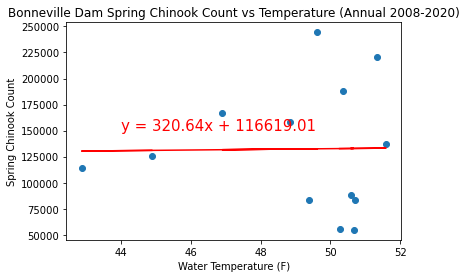

In [26]:
# Plot a scatter and regression of river depth and salmon counts to see if any correlation

slope, intercept, rvalue, pvalue, stderr = linregress(merged_annual_bonneville_salmon_data_df["temperature_f"], 
                                                      merged_annual_bonneville_salmon_data_df["Chin"])
regress_values =merged_annual_bonneville_salmon_data_df["temperature_f"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
print(f"The r2-value is: {rvalue**2}")
print(f"The p-value is: {pvalue}")

fig, ax = plt.subplots()
ax.set_xlabel("Water Temperature (F)")
ax.set_ylabel("Spring Chinook Count")
ax.set_title("Bonneville Dam Spring Chinook Count vs Temperature (Annual 2008-2020)")
ax.annotate(line_eq, (44,150000), fontsize=15, color="red")
ax.plot(merged_annual_bonneville_salmon_data_df["temperature_f"], regress_values, "r-")
ax.scatter(merged_annual_bonneville_salmon_data_df["temperature_f"], merged_annual_bonneville_salmon_data_df["Chin"])
plt.savefig(annual_image_path + "bonn_below_annual_scatter_temp.png")
plt.show()